In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import time

from textblob import TextBlob

%matplotlib inline

In [23]:
def loglikely(n1, t1, n2, t2):
    """Calculates Dunning log likelihood of an observation of 
    frequency n1 in a corpus of size t1, compared to a frequency n2 
    in a corpus of size t2. If result is positive, it is more 
    likely to occur in corpus 1, otherwise in corpus 2."""
    from numpy import log
    e1 = t1*1.0*(n1+n2)/(t1+t2) # expected values
    e2 = t2*1.0*(n1+n2)/(t1+t2)
    LL = 2 * ((n1 * log(n1/e1)) + n2 * (log(n2/e2)))
    if n2*1.0/t2 > n1*1.0/t1:
        LL = -LL
    return LL

Special tweet parser

In [2]:
## emoticons
emoticons_str = r"""
  (?:
    [:=;] # Eyes
    [oO\-]? # Nose (optional)
    [D\)\]\(\]/\\OpP] # Mouth
  )"""
 
## words
regex_str = [
  emoticons_str,
  r'<[^>]+>', # HTML tags
  r'(?:@[\w_]+)', # @-mentions
  r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
  r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

  r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
  r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
  r'(?:[\w_]+)', # other words
  r'(?:\S)' # anything else
]

## compile regex
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(string):
	return tokens_re.findall(string)

def removable(token):
	isEmoticon = True if emoticon_re.search(token) else False
	isRemovable = token in [',', '.', ':', ';']
	return (isEmoticon or isRemovable)

# pre_processor
def pre_process(string, lowercase=False):
	tokens = tokenize(string)
	tokens = [ token.lower() for token in tokens if not removable(token)]
	return tokens

Load curated dataset

In [38]:
df_curated = pd.concat([pd.read_csv('../twitfem/curated/davidt1.csv', encoding='latin-1'),
                        pd.read_csv('../twitfem/curated/nancy_classified.csv', encoding='latin-1')])
df_curated = df_curated[df_curated['class'].isin([0,1,2])]
df_curated.to_pickle('df_curated.pickle')
df_curated = df_curated[['id', 'tweet', 'class']]
def assign_polarity(cell):
    return TextBlob(cell).polarity
df_curated['polarity'] = df_curated.tweet.apply(assign_polarity)
def assign_subjectivity(cell):
    return TextBlob(cell).subjectivity
df_curated['subjectivity'] = df_curated.tweet.apply(assign_subjectivity)

Automated sentiment analysis does not differentiate pro- and anti-feminist tweets

Here is the automated polarity and subjectivity of neutral tweets:

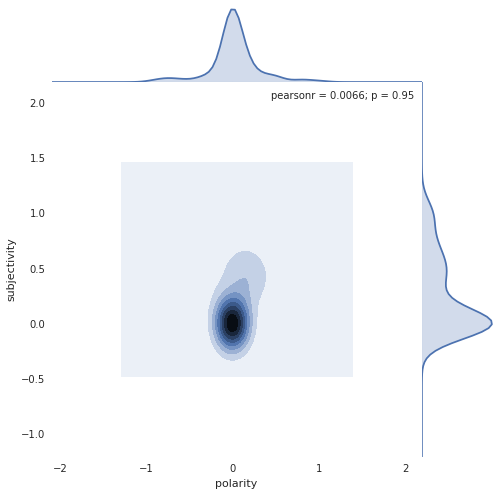

In [39]:
df_ = df_curated[df_curated['class'] == 0]
g = sns.jointplot(df_.polarity, df_.subjectivity, kind="kde", size=7, space=0)

Here is the automated polarity and subjectivity of pro-feminist tweets:

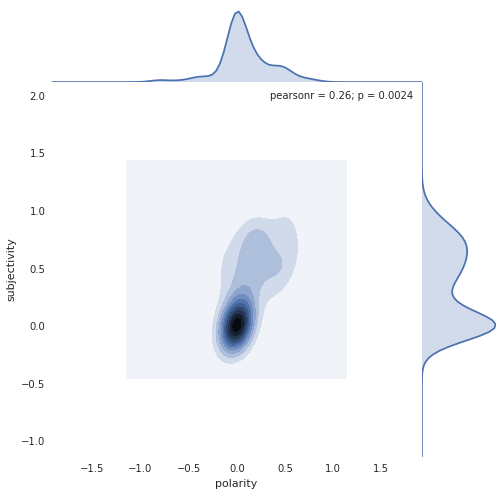

In [40]:
df_ = df_curated[df_curated['class'] == 1]
g = sns.jointplot(df_.polarity, df_.subjectivity, kind="kde", size=7, space=0)

Here is the automated polarity and subjectivity of anti-feminist tweets:

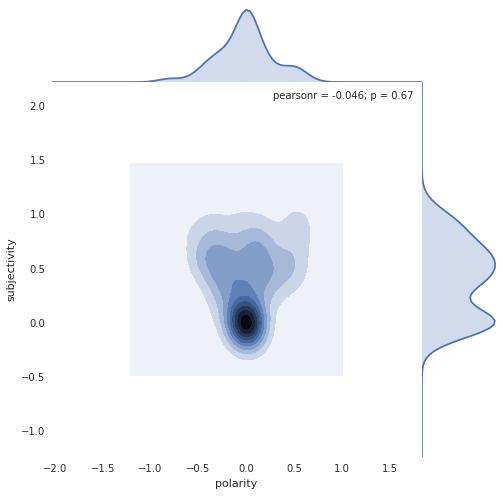

In [41]:
df_ = df_curated[df_curated['class'] == 2]
g = sns.jointplot(df_.polarity, df_.subjectivity, kind="kde", size=7, space=0)

A random forest classifier based on polarity and subjectivity achieves only 35.5% accuracy, compared to 33.3% for random choice.

In [42]:
from sklearn.ensemble import RandomForestClassifier
df_curated['is_train'] = np.random.uniform(0, 1, len(df_curated)) <= .75 # randomly assign training and testing set
train, test = df_curated[df_curated['is_train']==True], df_curated[df_curated['is_train']==False]
features = ['polarity', 'subjectivity']
y, _ = pd.factorize(train['class'])
clf = RandomForestClassifier(n_jobs=2)
clf = clf.fit(train[features], y)
preds = clf.predict(test[features])
test_result = pd.crosstab(test['class'], preds,
                      rownames=['actual'], colnames=['predicted'])
test_result

predicted,0,1,2
actual,,,
0,23,0,3
1,27,5,7
2,18,1,5


In [43]:
df1M = pd.read_csv('../twitfem/twitfem.csv', encoding='latin-1')
print(len(df1M))
df_nort = df1M[~df1M.tweet.str.contains('RT')]
print(len(df_nort))

988202
391284


Vectorize curated tweets and train a Naive Bayes classifier

In [48]:
df_curated.reset_index(drop=True, inplace=True)

In [49]:
df_curated = df_curated.reindex(np.random.permutation(df_curated.index))
train_size = int(len(df_curated) * .75)
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer=pre_process)
bagofwords = vec.fit_transform(df_curated.tweet)
bagofwords = bagofwords.toarray()
train = bagofwords[:train_size,:]
test = bagofwords[train_size:,:]
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train, df_curated[:train_size]['class'])
predicted = clf.predict(test)
pd.crosstab(df_curated[train_size:]['class'], predicted,
                      rownames=['actual'], colnames=['predicted'])

predicted,0.0,1.0,2.0
actual,,,
0,4,14,3
1,4,24,5
2,4,12,10


Our classifier has 50-55% accuracy; better than 33.3%, to be sure

Predict the class of all 391,000 tweets

In [52]:
%%time
bagofwords = vec.fit(df_curated.tweet)
nort_vector = bagofwords.transform(df_nort.tweet)
predicted_nort = clf.predict(nort_vector)
df_nort['class'] = predicted_nort
df_nort.to_pickle('twitfem_391K_classified.pickle')

/software/CentOS-6/tools/python-3.3.2/lib/python3.3/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
df_nort = pd.read_pickle('twitfem_391K_classified.pickle')

In [3]:
df_nort['class'].value_counts()

1    264716
0     67537
2     59031
dtype: int64

Function to count word frequencies

In [53]:
from collections import Counter
import pandas as pd

def countit(df, thisClass):
    df = df[df['class'] == thisClass]
    numItems = len(df)
    count = Counter()
    for key, row in df.iterrows():
        terms = [ term for term in pre_process( row['tweet'] ) ]
        count.update(terms)
        
    toBeReturned = pd.DataFrame(columns=['class', 'token', 'frequency'])
    tokenList = []
    frequencyList = []
    classList = []
    for token,frequency in count.items():
        tokenList.append(token)
        frequencyList.append(frequency)
        classList.append(thisClass)

    theDict = { 'token':tokenList, 'freq': frequencyList, 'class': classList } 
    return pd.DataFrame.from_dict(theDict)

In [54]:
%%time
df_freqs = pd.concat([countit(df_nort, 1), countit(df_nort, 2)])

CPU times: user 1min 18s, sys: 161 ms, total: 1min 18s
Wall time: 1min 18s


In [55]:
class ProgressBar: 
    """ Init with loop_length, i.e. number of events that add up to 100%, then use methods
    .increment() for each event, and .finish() when complete. """
    def __init__(self, loop_length):
        import time
        self.start = time.time()
        self.increment_size = 100.0/loop_length
        self.curr_count = 0
        self.curr_pct = 0
        self.overflow = False
        print('% complete:', end=' ')
    
    def increment(self):
        self.curr_count += self.increment_size
        if int(self.curr_count) > self.curr_pct:
            self.curr_pct = int(self.curr_count)
            if self.curr_pct <= 100:
                print (self.curr_pct, end=' ')
            elif self.overflow == False:
                print("\n*!* Count has gone over 100%; likely either due to:\n*!*   - an error in the loop_length specified when " + \
                      "progress_bar was instantiated\n*!*   - an error in the placement of the increment() function")
                print('*!* Elapsed time when progress bar full: %0.1f seconds.' % (time.time() - self.start))
                self.overflow = True

    def finish(self):
        if self.curr_pct == 99:
            print("100"), # this is a cheat, because rounding sometimes makes the maximum count 99. One day I'll fix this bug.
        if self.overflow == True:
            print('*!* Elapsed time after end of loop: %0.1f seconds.\n' % (time.time() - self.start))
        else:
            print('\nElapsed time: %0.1f seconds.\n' % (time.time() - self.start))

In [56]:
df_freqs.to_pickle('df_freqs.pickle')

In [6]:
df_freqs = pd.read_pickle('df_freqs.pickle')

In [57]:
df_freqs['loglikely'] = 0.0
t1 = df_freqs[df_freqs['class'] == 1].freq.sum()
t2 = df_freqs[df_freqs['class'] == 2].freq.sum()
tokens = []
loglikelies = []
cutoff = 10
df_freqs = df_freqs[df_freqs.freq >= cutoff]
pbar = ProgressBar(len(df_freqs.token.unique()))
for token in df_freqs.token.unique():
    pbar.increment()
    try:
        n1 = df_freqs[(df_freqs['class'] == 1) & (df_freqs.token == token)].freq.iloc[0]
    except:
        n1 = 0
    try:
        n2 = df_freqs[(df_freqs['class'] == 2) & (df_freqs.token == token)].freq.iloc[0]
    except:
        n2 = 0
    if n1 > cutoff and n2 > cutoff:
        tokens.append(token)
        loglikelies.append(loglikely(n1, t1, n2, t2))
pbar.finish()
df_result = pd.DataFrame({'token': tokens, 'loglikely': loglikelies})

% complete: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100

Elapsed time: 126.1 seconds.



In [61]:
df_result = pd.DataFrame({'token': tokens, 'loglikely': loglikelies})

In [62]:
df_result.sort('loglikely', inplace=True)
df_result.to_csv('loglikelihoods.csv')

In [10]:
df_result = pd.read_csv('loglikelihoods.csv')
#df_result.to_csv('loglikelihoods.csv')

In [63]:
df_result.head(50)

,loglikely,token
3350,-32811.468363,feminists
1746,-13441.173828,u0001f602
768,-8191.663686,was
1809,-4549.528872,@youtube
2311,-3634.654054,liked
4881,-3314.636427,>
2030,-3272.928158,they
1130,-3122.630694,their
1053,-2638.176647,twitter
2525,-2543.454412,video


In [64]:
df_result.tail(50)

,loglikely,token
1112,429.743482,ur
2917,430.930516,tell
1519,442.299837,no
4099,447.581908,rights
1365,455.281644,/
3074,457.729082,word
1567,477.748929,been
554,516.691421,means
3572,524.705619,our
986,543.158526,love


In [15]:
df_2search = df_nort[df_nort['class'].isin([1,2])]
def re_tokenize(row):
    lst = pre_process(row.tweet)
    return(' '.join(lst))
df_2search['tokens'] = df_2search.apply(re_tokenize, axis=1)

/software/CentOS-6/tools/python-3.3.2/lib/python3.3/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
token = 'we'
found1 = df_2search[df_2search.tokens.str.contains(' ' + token + ' ')]
found2 = df_2search[df_2search.tokens.str.contains('^' + token + ' ')]
found3 = df_2search[df_2search.tokens.str.contains(' ' + token + '$')]
found = pd.concat([found1, found2, found3])
found = found.reindex(np.random.permutation(df_curated.index))
f1 = 
print('WORD: {}'.format(token))
print('PRO: {}'.format(len(found[found['class
for i in range(10):
    print(x.tweet.iloc[i])

15593 1510 17
College cancels production of \u2018The Vagina Monologues\u2019 because it doesn\u2019t include women who don\u2019t have vaginas: http://t.co/m3ElbsxB7Q
\u201c"My response to the \u201cI am not a feminist\u201d internet phenomenon\u2026. First of all, it\u2019s clear you don\u2019t know wha \u2026 http://t.co/FwN3jvm7rQ
6 Things That Don\u2019t Make You A Bad Feminist (No Matter What Anyone Says): One thing that\u2026 http://t.co/zexIiVKscB
Don\u2019t blame Emma Watson\u2019s speech for liberal feminist\xa0failures.   http://t.co/Wpj8ZDUslC via @RoomOfOurOwn
6 Things That Don\u2019t Make You A Bad Feminist (No Matter What Anyone\xa0Says) http://t.co/ElFtL4fqN9
6 Things That Don\u2019t Make You A Bad Feminist (No Matter What Anyone Says) http://t.co/lNCAUL39bS #9jaFreebie
6 Things That Don\u2019t Make You A Bad Feminist (No Matter What Anyone\xa0Says) http://t.co/ezmN3eQrYu
6 Things That Don\u2019t Make You A Bad Feminist (No Matter What Anyone\xa0Says) http://t.co/kAWzqO

In [12]:
found

,Unnamed: 0,term,id,tweet,return_num,total_num,db_entered_time,tweeted_time,followers,reply_id,favorite_count,retweet_count,retweeted,user_location_text,statuses_count,utc_offset,account_created,class,tokens
442,442,feminist,556256003944378368,College cancels production of \u2018The Vagina...,43,100,2015-01-17 01:09:10,2015-01-17 01:05:40,161,0,0,0,0,Last in Line,7079,-18000,2011-03-15 03:41:54,1,college cancels production of \ u2018the vagin...
2153,2185,feminist,556514187422093313,"\u201c""My response to the \u201cI am not a fem...",14,100,2015-01-17 18:13:14,2015-01-17 18:11:36,376,0,0,0,0,NaN,31222,-28800,2011-05-28 06:52:23,0,"\ u201c "" my response to the \ u201ci am not a..."
2558,2590,feminist,556558450105135104,6 Things That Don\u2019t Make You A Bad Femini...,24,100,2015-01-17 21:09:23,2015-01-17 21:07:29,250,0,0,0,0,Kaduna,41437,NaN,2013-07-09 12:57:21,1,6 things that don \ u2019t make you a bad femi...
2563,2595,feminist,556558339522703361,Don\u2019t blame Emma Watson\u2019s speech for...,29,100,2015-01-17 21:09:23,2015-01-17 21:07:03,2629,0,0,0,0,NaN,12778,NaN,2013-12-10 11:21:48,0,don \ u2019t blame emma watson \ u2019s speech...
2578,2610,feminist,556558103035265024,6 Things That Don\u2019t Make You A Bad Femini...,44,100,2015-01-17 21:09:23,2015-01-17 21:06:06,1092,0,0,0,0,World Wide,29371,3600,2012-02-08 12:30:03,1,6 things that don \ u2019t make you a bad femi...
2579,2611,feminist,556558102523162624,6 Things That Don\u2019t Make You A Bad Femini...,45,100,2015-01-17 21:09:23,2015-01-17 21:06:06,3155,0,0,0,0,Nigeria & Uk,11261,21600,2013-08-02 22:03:32,1,6 things that don \ u2019t make you a bad femi...
2589,2621,feminist,556557991969697792,6 Things That Don\u2019t Make You A Bad Femini...,55,100,2015-01-17 21:09:23,2015-01-17 21:05:40,1207,0,0,0,0,Ibadan,30115,NaN,2011-07-22 13:53:57,1,6 things that don \ u2019t make you a bad femi...
2590,2622,feminist,556557977360945152,6 Things That Don\u2019t Make You A Bad Femini...,56,100,2015-01-17 21:09:23,2015-01-17 21:05:36,535,0,0,0,0,inYoRibs,34688,3600,2011-05-06 12:04:24,1,6 things that don \ u2019t make you a bad femi...
2591,2623,feminist,556557970004127744,6 Things That Don\u2019t Make You A Bad Femini...,57,100,2015-01-17 21:09:23,2015-01-17 21:05:35,245,0,0,0,0,Abuja,38293,-36000,2011-07-06 10:50:05,1,6 things that don \ u2019t make you a bad femi...
2592,2624,feminist,556557962634731521,6 Things That Don\u2019t Make You A Bad Femini...,58,100,2015-01-17 21:09:23,2015-01-17 21:05:33,635,0,0,0,0,Kidnapper oshi ( \u02d8\u02d8\u032f) \u250c\u0...,45766,NaN,2011-05-16 15:46:04,1,6 things that don \ u2019t make you a bad femi...


In [ ]:
df_nort[df_nort.t